# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 9

In [2]:
%reload_ext autoreload
%autoreload 2

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [85]:
from data_generation.square_sequences import generate_sequences
from plots.chapter8 import counter_vs_clock, plot_sequences, plot_data
from plots.chapter9 import sequence_pred, figure9, query_and_keys, plot_attention
from stepbystep.v1 import StepByStep

# Part I

# Sequence-to-Sequence

## Data Generation

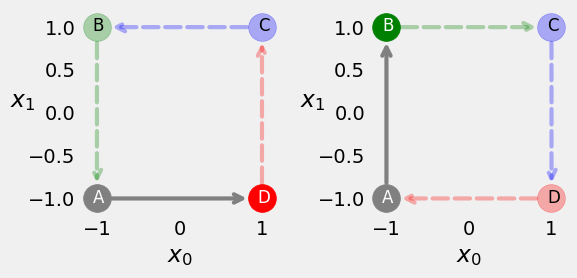

In [4]:
fig = counter_vs_clock(binary=False)

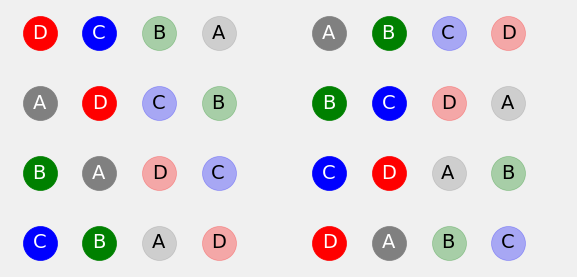

In [6]:
fig = plot_sequences(binary=False, target_len=2)

In [8]:
points, directions = generate_sequences(n=256, seed=13)

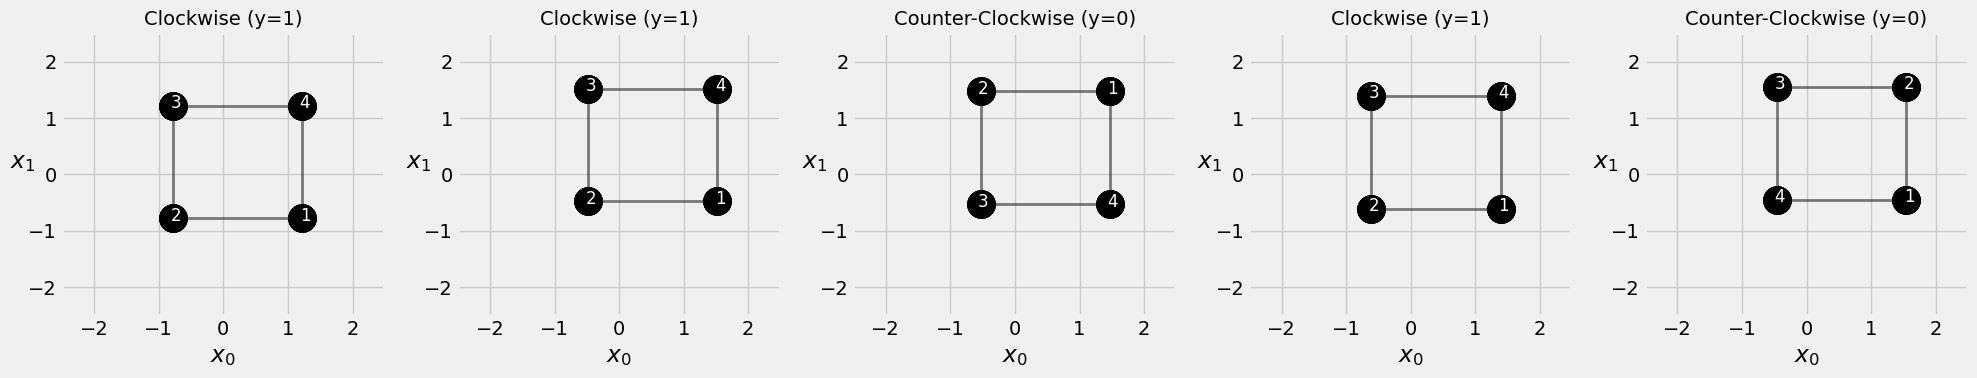

In [10]:
fig = plot_data(points, directions, n_rows=1)

## Encoder-Decoder Architecture

### Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

    def forward(self, x):
        rnn_out, self.hidden = self.basic_rnn(x)

        return rnn_out  # N, L, F

In [14]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

In [15]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)    # output is N, L, F
hidden_final = hidden_seq[:, -1:]   # takes last hidden state
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

### Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.regression = nn.Linear(self.hidden_dim, self.n_features)

    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:]  # N, 1, H
        
        # Initialize decoder’s hidden state using encoder’s final hidden state.
        # But we need to make it sequence-first
        self.hidden = hidden_final.permute(1, 0, 2)  # 1, N, H

    def forward(self, x):
        # x is N, 1, F
        # The recurrent layer both uses and updates the hidden state.
        batch_first_output, self.hidden = self.basic_rnn(x, self.hidden) 

        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)

        # The output has the same shape as the input (N, 1, F).
        return out.view(-1, 1, self.n_features)

In [17]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)   # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



#### Teacher Forcing

In [18]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates    
    print(f'Output: {out}\n')
    # But completely ignores the predictions and uses real data instead
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward0>)



In [19]:
# Initial hidden state is encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)
    print(f'Output: {out}\n')
    # If it is teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        # Takes the actual element
        inputs = target_seq[:, i:i+1]
    else:
        # Otherwise uses the last predicted output
        inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



### Encoder + Decoder

In [20]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)

    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out

    def forward(self, x):               
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = x[:, :self.input_len, :]
        target_seq = x[:, self.input_len:, :]
        self.init_outputs(x.shape[0])        

        # Encoder expected N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)

        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]

        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)

            prob = self.teacher_forcing_prob
            # In evaluation/test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0

            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actual element
                dec_inputs = target_seq[:, i:i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out

        return self.outputs

In [23]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)

In [24]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

In [25]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [-0.0226,  0.4628]]], grad_fn=<CopySlices>)

### Data Preparation

In [28]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(np.array(points)).float()
target_train = full_train[:, 2:]

In [29]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [31]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Training & Configuration

In [33]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [35]:
sbs_seq = StepByStep(model, loss_fn, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

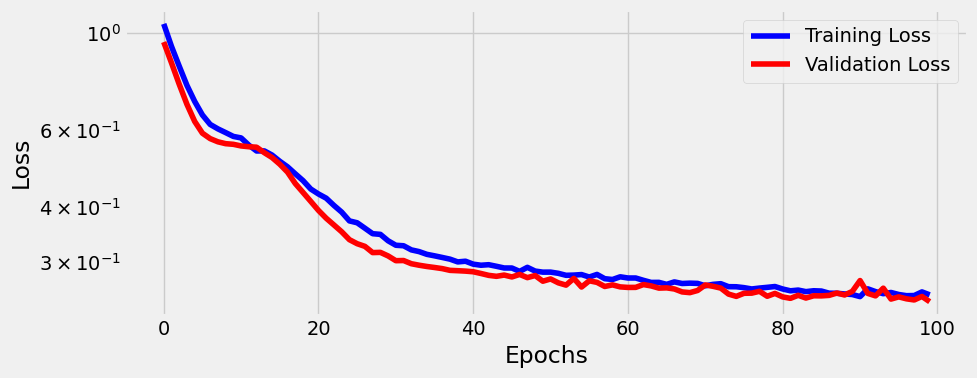

In [36]:
fig = sbs_seq.plot_losses()

### Visualizing Predictions

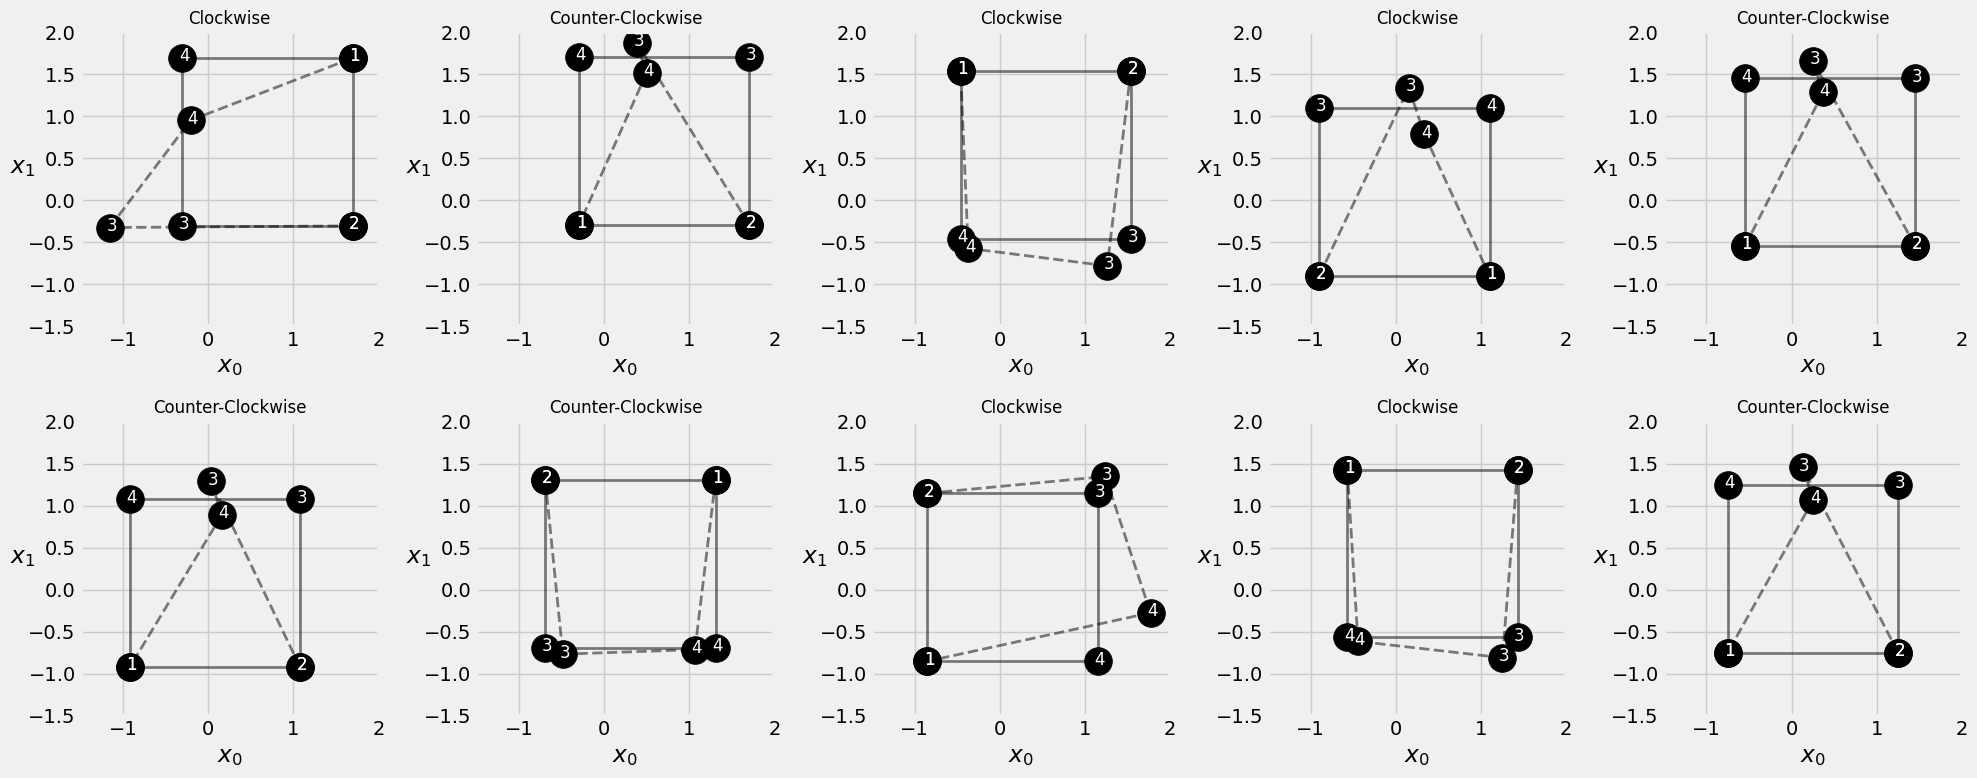

In [42]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

## Attention

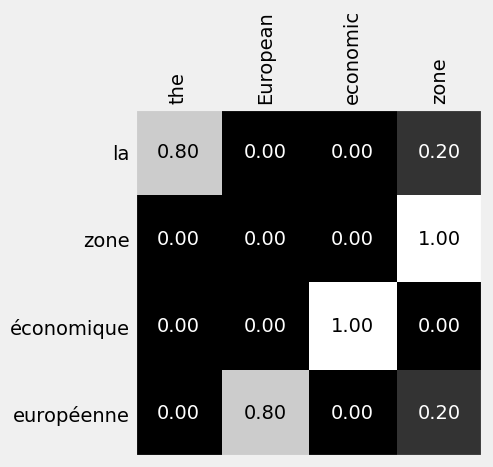

In [44]:
fig = figure9()

### "Values"

$$
\Large
\text{context vector} = \underbrace{\alpha_0 * h_0}_{\text{alignment vector}_0} + \underbrace{\alpha_1 * h_1}_{\text{alignment vector}_1} = 0.8 * \text{value}_{the} + 0.2 *\text{value}_{zone}
$$

### "Keys" and "Queries"

### Computing the Context Vector

In [45]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [46]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)

values = hidden_seq  # N, L, H
values

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [47]:
keys = hidden_seq  # N, L, H
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [48]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs = source_seq[:, -1:]
out = decoder(inputs)

In [49]:
query = decoder.hidden.permute(1, 0, 2)  # N, 1, H
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward0>)

In [50]:
def calc_alphas(ks, q):
    N, L, H = ks.size()
    alphas = torch.ones(N, 1, L).float() * 1/L
    return alphas

alphas = calc_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

$$
\Large
(\textcolor{green}{N}, 1, \textcolor{red}{L}) \times 
(\textcolor{green}{N}, \textcolor{red}{L}, H) = 
(\textcolor{green}{N}, 1, H)
$$

In [51]:
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

In [52]:
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward0>)

### Scoring Method

$$
\Large
\text{cos}\ \theta = \frac{\sum_i{q_ik_i}}{\sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}}
$$

$$
\Large
\text{cos}\ \theta \sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}= \sum_i{q_ik_i}
$$

$$
\Large
\text{cos}\ \theta\ ||Q||\ ||K|| = Q \cdot K
$$

In [53]:
# N, 1, H x N, H, L -> N, 1, L
products = torch.bmm(query, keys.permute(0, 2, 1))
products

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

### Attention Scores

In [55]:
alphas = F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward0>)

In [56]:
def calc_alphas(ks, q):
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    alphas = F.softmax(products, dim=-1)    
    return alphas

### Visualizing the Context Vector

In [57]:
q = torch.tensor([.55, .95]).view(1, 1, 2) # N, 1, H
k = torch.tensor([[.65, .2], 
                  [.85, -.4], 
                  [-.95, -.75]]).view(1, 3, 2) # N, L, H

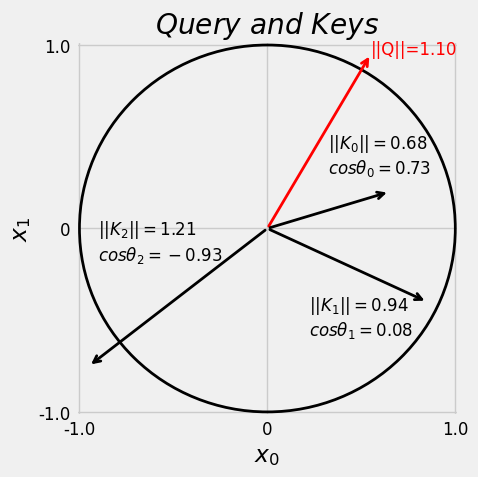

In [59]:
fig = query_and_keys(q.squeeze(), k.view(3, 2))

$$
\Large
\begin{array}{ccccrcr}
Q \cdot K_0 & = & cos \theta_0\ ||Q||\ ||K_0|| & = & 0.73 \ * \ 1.10 \ * \ 0.68 & = & 0.54
\\
Q \cdot K_1 & = & cos \theta_1\ ||Q||\ ||K_1|| & = & 0.08 \ * \ 1.10 \ * \ 0.94 & = & 0.08
\\
Q \cdot K_2 & = & cos \theta_2\ ||Q||\ ||K_2|| & = & -0.93 \ * \ 1.10 \ * \ 1.21 & = & -1.23
\end{array}
$$

In [60]:
# N, 1, H x N, H, L -> N, 1, L
prod = torch.bmm(q, k.permute(0, 2, 1))
prod

tensor([[[ 0.5475,  0.0875, -1.2350]]])

In [61]:
scores = F.softmax(prod, dim=-1)
scores

tensor([[[0.5557, 0.3508, 0.0935]]])

$$
\Large
\text{context vector}=
0.5557*
\begin{bmatrix}
0.65
\\
0.20
\end{bmatrix}
+
0.3508*
\begin{bmatrix}
\ \ 0.85
\\
-0.40
\end{bmatrix}
+
0.0935*
\begin{bmatrix}
-0.95
\\
-0.75
\end{bmatrix}
$$

In [62]:
v = k
context = torch.bmm(scores, v)
context

tensor([[[ 0.5706, -0.0993]]])

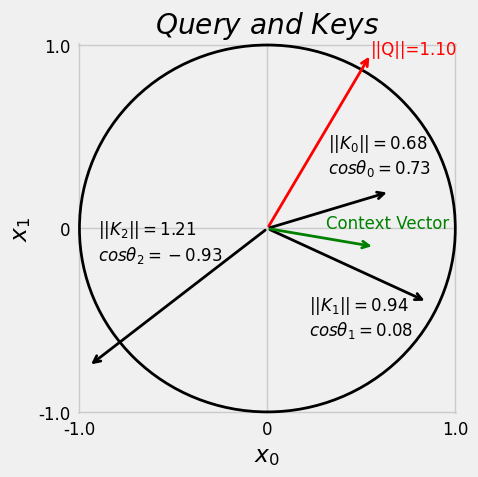

In [63]:
fig = query_and_keys(q.squeeze(), k.view(3, 2), context)

### Scaled Dot Product

$$
\Large
\text{scaled dot product} = \frac{Q \cdot K}{\sqrt{d_k}}
$$

In [64]:
dims = query.size(-1)
scaled_products = products / np.sqrt(dims)
scaled_products

tensor([[[0.0403, 0.3409]]], grad_fn=<DivBackward0>)

In [65]:
dummy_product = torch.tensor([4.0, 1.0])
F.softmax(dummy_product, dim=-1), F.softmax(100*dummy_product, dim=-1)

(tensor([0.9526, 0.0474]), tensor([1., 0.]))

In [66]:
alphas = F.softmax(scaled_products, dim=-1)
alphas

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward0>)

<div style="background-color: white; width: 50%">
    <img src="images/aiayn_dot.png">
</div>

In [67]:
def calc_alphas(ks, q):
    dims = q.size(-1)
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    scaled_products = products / np.sqrt(dims)
    alphas = F.softmax(scaled_products, dim=-1)    
    return alphas

In [68]:
alphas = calc_alphas(keys, query)
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

### Attention Mechanism

<div style="background-color: white; width: 50%">
    <img src="images/attention.png">
</div>

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None

    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) if self.proj_values else self.keys

    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def forward(self, query, mask=None):
        # First step: Alignment scores (scaled dot product)
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Second step: Attention scores (alphas)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()

        # Third step: Context vector
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Source Mask

In [71]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
# pretend there's an encoder here...
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-1., 1.]]])

In [72]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
source_mask # N, 1, L

tensor([[[ True, False]]])

In [73]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)

context = attnh(query, mask=source_mask)
attnh.alphas

tensor([[[1., 0.]]])

### Decoder

In [ ]:
class DecoderAttn(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.attn = Attention(self.hidden_dim)
        self.regression = nn.Linear(2 * self.hidden_dim, self.n_features)

    def init_hidden(self, hidden_seq):
        # the output of the encoder is N, L, H
        # and init_keys expects batch-first as well
        self.attn.init_keys(hidden_seq)
        hidden_final = hidden_seq[:, -1:]
        self.hidden = hidden_final.permute(1, 0, 2)   # L, N, H

    def forward(self, X, mask=None):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 

        query = batch_first_output[:, -1:]
        # Attention 
        context = self.attn(query, mask=mask)
        concatenated = torch.cat([context, query], axis=-1)
        out = self.regression(concatenated)

        # N, 1, F
        return out.view(-1, 1, self.n_features)

In [75]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [76]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
    out = decoder_attn(inputs)
    print(f'Output: {out}')    
    inputs = out

Output: tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward0>)
Output: tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward0>)


### Encoder + Decoder + Attention

<div style="background-color: white; width: 50%">
    <img src="images/encdec_attn.png">
</div>

In [77]:
encdec = EncoderDecoder(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.0)
encdec(full_seq)

tensor([[[-0.3555, -0.1220],
         [-0.2641, -0.2521]]], grad_fn=<CopySlices>)

In [78]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        self.alphas = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
        # N, L (target), L (source)
        self.alphas = torch.zeros(batch_size, 
                                  self.target_len, 
                                  self.input_len).to(device)

    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        self.alphas[:, i:i+1, :] = self.decoder.attn.alphas

### Model Configuration & Training

In [79]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [80]:
sbs_seq_attn = StepByStep(model, loss_fn, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)

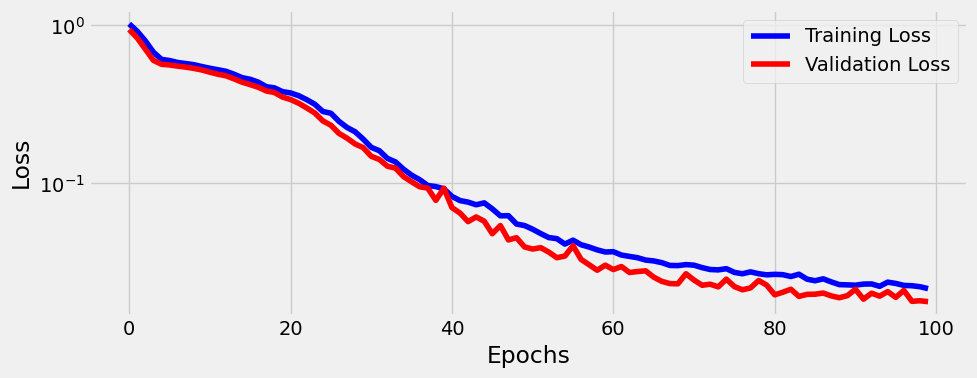

In [81]:
fig = sbs_seq_attn.plot_losses()

### Visualizing Predictions

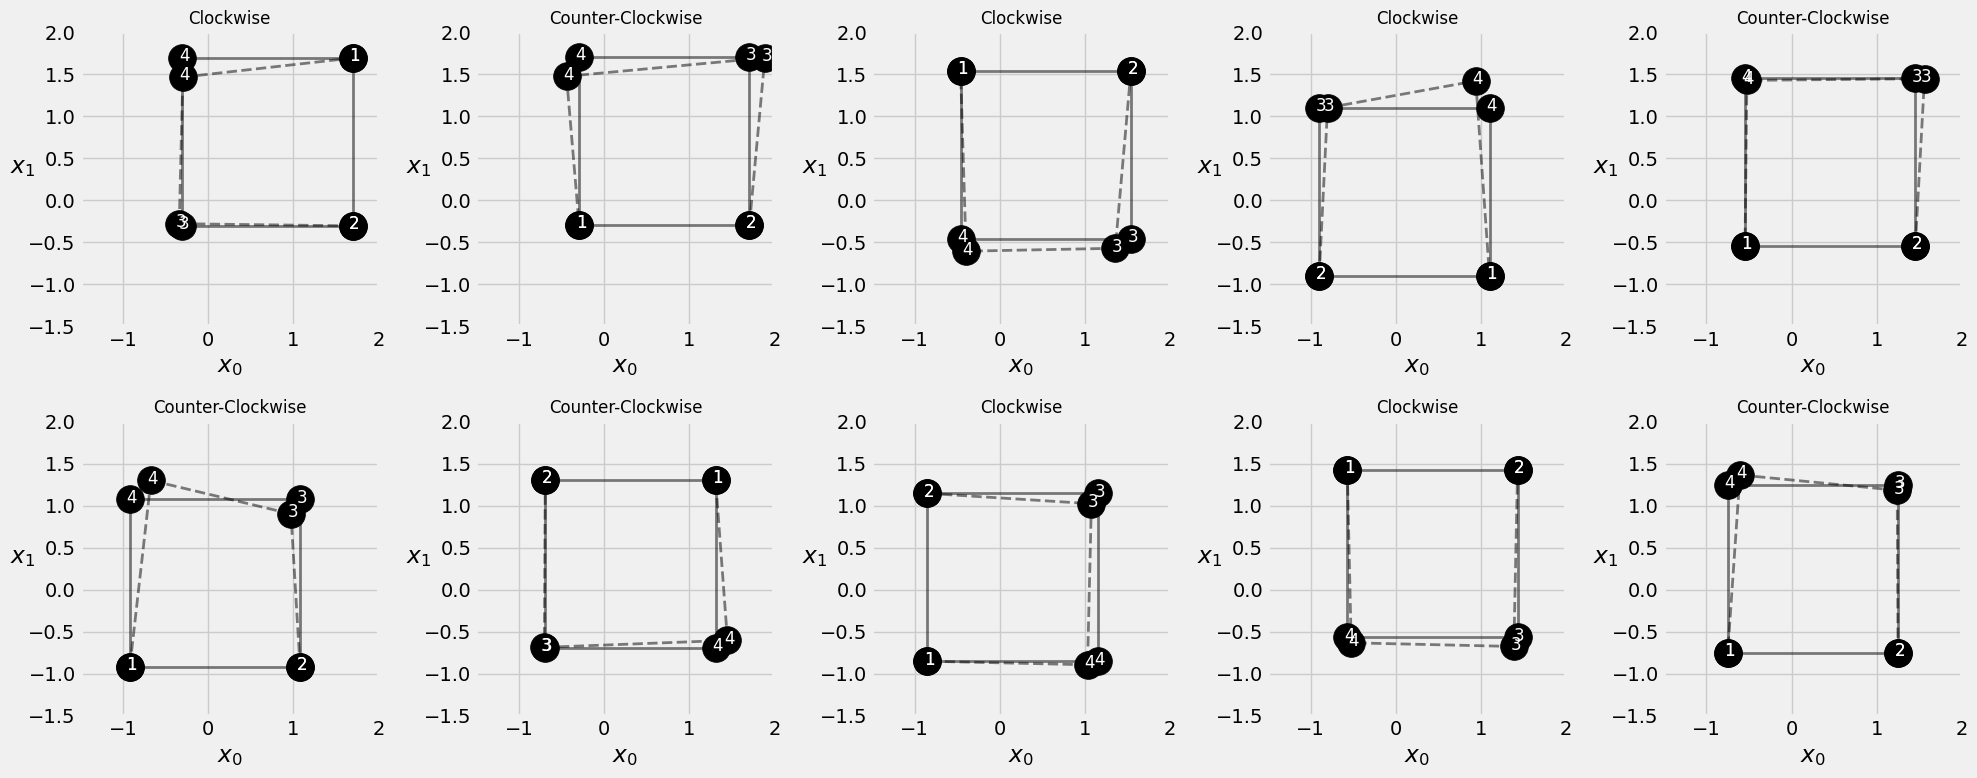

In [82]:
fig = sequence_pred(sbs_seq_attn, full_test, test_directions)

### Visualizing Attention

In [83]:
inputs = full_train[:1, :2]
out = sbs_seq_attn.predict(inputs)
sbs_seq_attn.model.alphas

tensor([[[9.9052e-01, 9.4753e-03],
         [1.2264e-04, 9.9988e-01]]], device='cuda:0')

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & \alpha_{\color{green}{2}\color{red}0} & \alpha_{{\color{green}{2}\color{red}1}} \\
 \color{green}{x_3} & \alpha_{\color{green}{3}\color{red}0} & \alpha_{{\color{green}{3}\color{red}1}}
\end{array}
\implies
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & 0.8196 & 0.1804\\
 \color{green}{x_3} & 0.7316 & 0.2684
\end{array}
$$

In [84]:
inputs = full_train[:10, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

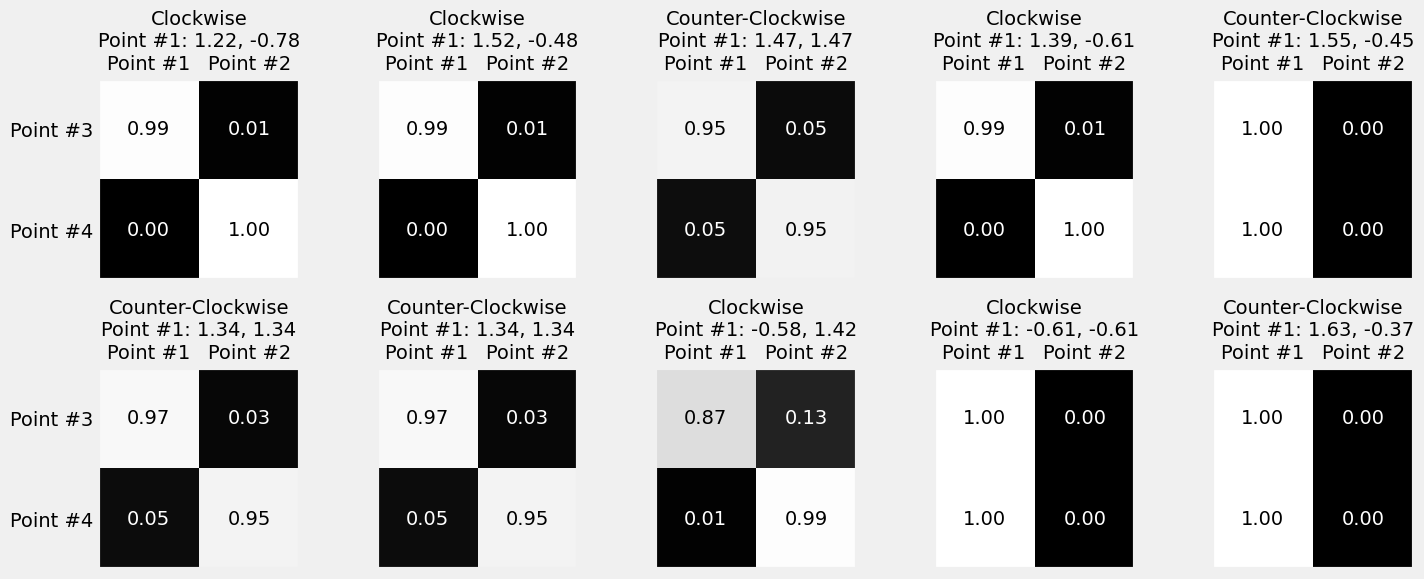

In [86]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels)

### Multi-Headed Attention

<div style="background-color: white; width: 50%">
    <img src="images/multiattn.png">
</div>

<div style="background-color: white; width: 50%">
    <img src="images/aiayn_multihead.png">
</div>

In [87]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])

    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)

    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)

    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out

    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out